# __1-D DFT Code for harmonic Osciilator__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

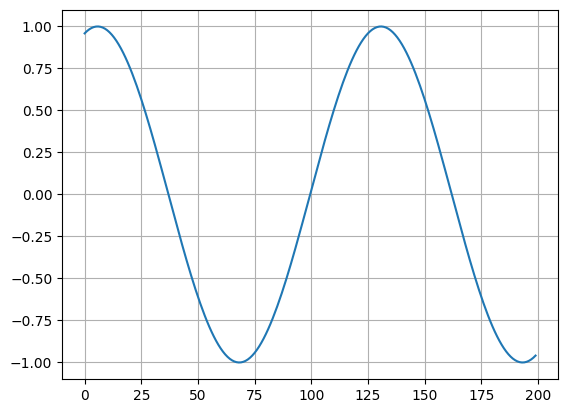

In [16]:
n_grid=200
x=np.linspace(-5,5,n_grid)
y=np.sin(x)
plt.plot(y)
plt.grid()
h=x[1]-x[0]

In [18]:
D=-np.eye(n_grid)+np.diagflat(np.ones(n_grid-1),1)
D = D / h
print(D)

[[-19.9  19.9   0.  ...   0.    0.    0. ]
 [  0.  -19.9  19.9 ...   0.    0.    0. ]
 [  0.    0.  -19.9 ...   0.    0.    0. ]
 ...
 [  0.    0.    0.  ... -19.9  19.9   0. ]
 [  0.    0.    0.  ...   0.  -19.9  19.9]
 [  0.    0.    0.  ...   0.    0.  -19.9]]
